# Neural Operator Robustness - Quick Demo

This notebook provides a quick demonstration of the key results from our neural operator robustness study.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import yaml
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
sys.path.append('../experiments/naca')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Imports complete")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

✅ Imports complete
Device: cuda


In [13]:
from utils import relative_l2_error

## 1. Load Configuration

In [14]:
# Load NACA configuration as example
config_path = '../experiments/naca/config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("📋 Configuration loaded!")
print(f"\nExperiment: NACA Airfoil Flow Prediction")
print(f"Models: {config['models']['types_don'] + config['models']['types_fno']}")
print(f"Noise types: {config['noise_testing']['types']}")
print(f"Noise levels: {config['noise_testing']['levels']}")

📋 Configuration loaded!

Experiment: NACA Airfoil Flow Prediction
Models: ['default', 'nomad', 'ortho_layer_ica', 'fourier', 'fourier_layer_ortho']
Noise types: ['partial_random', 'harmonic_spatial', 'bandlimited_lowpass', 'bandlimited_highpass', 'spatial_block_noise']
Noise levels: [0.0, 0.1, 0.2, 0.5, 1.0]


In [15]:
res = 1
for r in config['data']['resolution']:
    res *= r
batch_size = config['data']['batch_size']
width = config['hyperparameters']['width_don']

## 2. Load Pre-trained Model and Make Predictions

In [16]:
from utils_naca import load_data, create_model

# Load data
print("Loading data...")
data_dict = load_data(config)

# Load a pre-trained model
model_type = 'default'  # DeepONet
seed = 0

print(f"\nLoading {model_type} model (seed={seed})...")
model = create_model(model_type, config, data_dict['branch_input_size'])
model_path = Path(config['paths']['save_models']) / f"best_model_{model_type}_res{res}_b{batch_size}_w{width}_d3_HD128_relu_seed{seed}_lrchd.pth"

if model_path.exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
else:
    print(f"❌ Model file not found at {model_path}")
    print("Please run training first: python experiments/naca/train.py")

Loading data...

📊 Loading NACA data...
  Raw data shapes:
    X coords: (2490, 221, 51)
    Y coords: (2490, 221, 51)
    Output: (2490, 221, 51)

  Data split:
    Training: torch.Size([1000, 221, 51, 2]), torch.Size([1000, 221, 51])
    Testing: torch.Size([200, 221, 51, 2]), torch.Size([200, 221, 51])

  Computing Fourier descriptors (64 harmonics)...
    Branch input shape: (1000, 128)
✅ Data loading complete!

Loading default model (seed=0)...
✅ Model loaded successfully!


In [17]:
# Make a prediction on test data
test_loader = data_dict['test_loader_don']
sample_batch = next(iter(test_loader))

with torch.no_grad():
    x_branch, x_trunk = sample_batch[0]
    y_true = sample_batch[1]
    
    x_branch = x_branch.to(device)
    x_trunk = x_trunk.to(device)
    y_true = y_true.to(device)
    
    # Get prediction
    y_pred = model(x_branch, x_trunk)  # Predict 4 samples

print(f"Sample predictions made!")

Sample predictions made!


## 3. Visualize Predictions

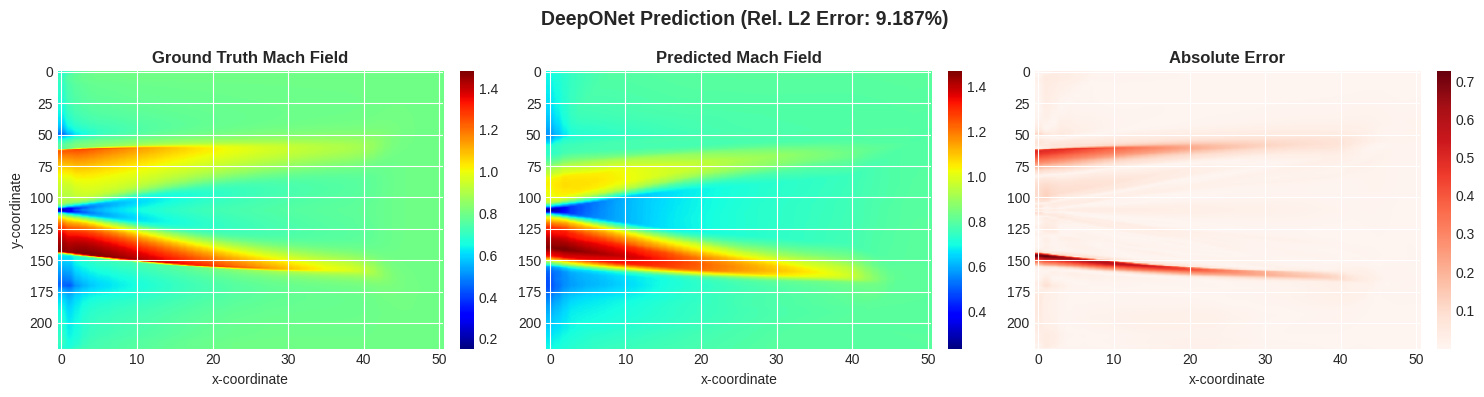

In [18]:
# Visualize one prediction
s1, s2 = data_dict['s1'], data_dict['s2']

# Reshape for visualization
y_true_vis = y_true[0].cpu().reshape(s1, s2).numpy()
y_pred_vis = y_pred[0].cpu().reshape(s1, s2).numpy()
error = np.abs(y_true_vis - y_pred_vis)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Ground truth
im1 = axes[0].imshow(y_true_vis, cmap='jet', aspect='auto')
axes[0].set_title('Ground Truth Mach Field', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x-coordinate')
axes[0].set_ylabel('y-coordinate')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Prediction
im2 = axes[1].imshow(y_pred_vis, cmap='jet', aspect='auto')
axes[1].set_title('Predicted Mach Field', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x-coordinate')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Error
im3 = axes[2].imshow(error, cmap='Reds', aspect='auto')
axes[2].set_title('Absolute Error', fontsize=12, fontweight='bold')
axes[2].set_xlabel('x-coordinate')
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

rel_error = np.linalg.norm(error) / np.linalg.norm(y_true_vis)
plt.suptitle(f'DeepONet Prediction (Rel. L2 Error: {rel_error:.3%})', 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Test Noise Robustness

Testing noise robustness (partial_random)...

Noise σ=0.0: Rel. L2 Error = 7.025%
Noise σ=0.1: Rel. L2 Error = 6.963%
Noise σ=0.2: Rel. L2 Error = 7.441%
Noise σ=0.5: Rel. L2 Error = 8.285%


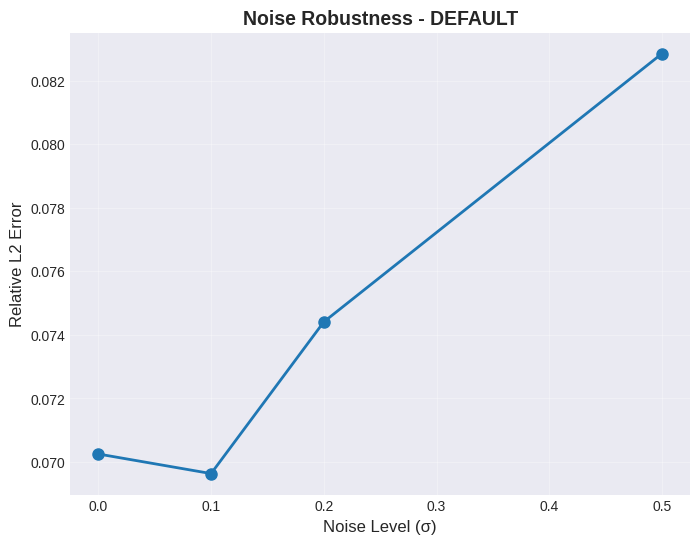

In [19]:
from noise_generators import NoiseGeneratorNACA

# Initialize noise generator
batch_size = 4
noise_gen = NoiseGeneratorNACA(x_shape=(batch_size, s1, s2), device=device)

# Test with different noise levels
noise_levels = [0.0, 0.1, 0.2, 0.5]
noise_type = 'partial_random'

results = []

print(f"Testing noise robustness ({noise_type})...\n")

for noise_level in noise_levels:
    # Get clean input
    x_branch_clean = x_branch[:batch_size].to(device)
    x_trunk_batch = x_trunk[:batch_size].to(device)
    y_true_batch = y_true[:batch_size].to(device)
    
    # Apply noise to branch input (simulated)
    # In real implementation, we would apply noise to the original coordinates
    # and recompute Fourier descriptors
    if noise_level > 0:
        noise = torch.randn_like(x_branch_clean) * noise_level
        x_branch_noisy = x_branch_clean + noise
    else:
        x_branch_noisy = x_branch_clean
    
    with torch.no_grad():
        y_pred_noisy = model(x_branch_noisy, x_trunk_batch)
        
        # Calculate error
        mean_error = relative_l2_error(y_true_batch.cpu(), y_pred_noisy.cpu())
        results.append({'noise_level': noise_level, 'rel_l2': mean_error})
        
        print(f"Noise σ={noise_level:.1f}: Rel. L2 Error = {mean_error:.3%}")

# Plot results
df_results = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
plt.plot(df_results['noise_level'], df_results['rel_l2'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Noise Level (σ)', fontsize=12)
plt.ylabel('Relative L2 Error', fontsize=12)
plt.title(f'Noise Robustness - {model_type.upper()}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Training

In [20]:
from train import train_model

trained_model, best_loss = train_model(
                model,
                data_dict['train_loader_don'],
                data_dict['test_loader_don'],
                config,
                model_type,
                88 # seed
            )


🚀 Training default with seed 88
  Epoch    1/2000 | Train: 0.098759 | Val: 0.076810 | Ortho: 0.000000
  Epoch  101/2000 | Train: 0.038076 | Val: 0.076140 | Ortho: 0.000000
  🛑 Early stopping at epoch 173
  ✅ Training complete!
     Parameters: 116,224
     Time: 69.3s
     Best val loss: 0.072955
